In [2]:
import os, shutil, pathlib, zipfile
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.utils import image_dataset_from_directory
from keras.applications import MobileNetV3Small
from keras.applications.mobilenet_v3 import preprocess_input

In [3]:
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall(".")

In [3]:
import os

num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


In [5]:
new_base_dir = pathlib.Path('men_vs_women_small')

In [5]:
def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in tqdm(fnames):
            src = os.path.join(base_dir, category, fname)
            dst = os.path.join(dir, fname)
            shutil.copyfile(src, dst)

In [ ]:
make_subset('traindata/traindata', 'validation', 0, 200)

In [ ]:
make_subset('traindata/traindata', 'train', 200, 1000)

In [ ]:
make_subset('testdata/testdata', 'test', 0, 400)

### Create Train/Validation/Test Datasets

In [7]:
batch_size = 16
image_size = (180, 180)

print('Train Loader:')
train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary')

print('Validation Loader:')
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary')

print('Test Loader:')
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary')

Train Loader:
Found 1600 files belonging to 2 classes.
Validation Loader:
Found 400 files belonging to 2 classes.
Test Loader:
Found 800 files belonging to 2 classes.


In [25]:
type(train_dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Data batch shape: (16, 180, 180, 3)
Label batch shape: (16, 1)


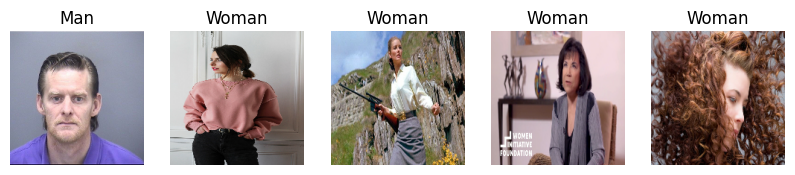

In [28]:
for data_batch, label_batch in train_dataset:
    print('Data batch shape:', data_batch.shape)
    print('Label batch shape:', label_batch.shape)

    fig, axes = plt.subplots(1, 5, figsize=(10, 3))
    for i in range(5):
        axes[i].imshow(data_batch[i].numpy().astype('uint8'))
        axes[i].set_axis_off()
        axes[i].set_title('Man' if label_batch[i].numpy()==0 else 'Woman')

    break

## Mdel Design

In [18]:
# if it failed to download, download the model manually using the provided url
# and move the model file to ~/.keras/models directory
conv_base = MobileNetV3Small(weights='imagenet', include_top=False)

/home/saeed/miniconda3/envs/dl/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:454: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [28]:
conv_base.summary()

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling_1[0][0] │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, None,      │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ None, 16)         │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

### Get Features from Conv_base

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

In [33]:
test_features.shape

(800, 5, 5, 576)

In [41]:
inputs = keras.Input(shape=train_features.shape[1:])
# Averages spatial dimensions to flatten the feature map
x = keras.layers.GlobalAveragePooling2D()(inputs)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 5, 5, 576)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,993 (144.50 KB)

 Trainable params: 36,993 (144.50 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
my_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_features,
    train_labels,
    epochs=15,
    validation_data=(val_features, val_labels),
    callbacks=my_callbacks,
)

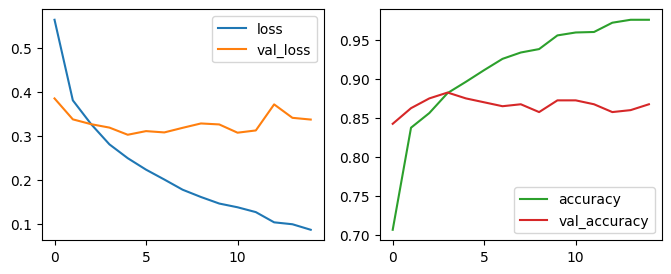

In [43]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [44]:
loss, acc = model.evaluate(test_features, test_labels)
print(f"Test Accuracy: {acc}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8888 - loss: 0.2925
Test Accuracy: 0.8887500166893005


### Augmentation + Feature Extraction + MLP

In [10]:
data_augmentation_model = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.2)
])

In [11]:
conv_base.trainable = False

In [12]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation_model(inputs)
x = preprocess_input(x)
x = conv_base(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.5*0.001),
    metrics=["accuracy"],
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 5, 5, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 976,113 (3.72 MB)

 Trainable params: 36,993 (144.50 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

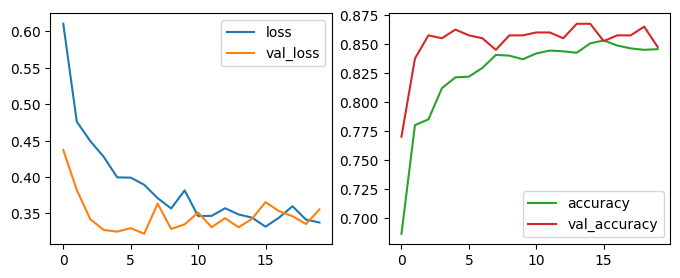

In [14]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [15]:
loss, acc = model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {acc}")

2025-12-18 16:58:26.168923: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
2025-12-18 16:58:26.745780: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
2025-12-18 16:58:26.818257: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
2025-12-18 16:58:27.157922: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


Test Accuracy: 0.8700000047683716
